In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
df = pd.read_pickle('tod.pkl')

In [17]:
bolo_time = df['bolotime']*3600.*24
df_tod = df.loc[:, df.columns!='bolotime']
signal = df_tod.values.T
det = df_tod.columns

In [22]:
def sample_rate(time):
    return 1/np.mean(np.diff(time))

def eigendecom(cov):
    E,R = np.linalg.eig(cov)
    E[np.isnan(E)] = 0.
    idx = np.argsort(-E)
    return E[idx], R[:, idx]

def create_nmodes(cov,nmodes,R,signal):
    R_n = R[:, :nmodes]
    modes = np.dot(R_n.transpose(), signal)
    return R_n, modes

def cm_subtract(signal,nmodes,det,ret_df=True):
    signal_cm = np.zeros_like(signal)
    cov = np.cov(signal)
    E,R = eigendecom(cov)
    R_n,modes = create_nmodes(cov,nmodes,R,signal)
    for i in range(len(E)):
        signal_cm[i] = signal[i] - np.dot(R_n[i, :], modes)
    
    if ret_df:
        return dataframe(signal_cm,det)
    else:
        return signal_cm

def dataframe(signal,col):
    df = pd.DataFrame(signal.T)
    df.columns = col
    return df

def plot_corr(df):
    plt.figure(figsize=(8,8))
    sns.heatmap(df.corr(),vmin=-1, vmax=1, center=0,
            cmap=sns.diverging_palette(20, 220, n=200),
            cbar_kws ={'shrink': .6, 'label': 'Correlation'},
            square=True)

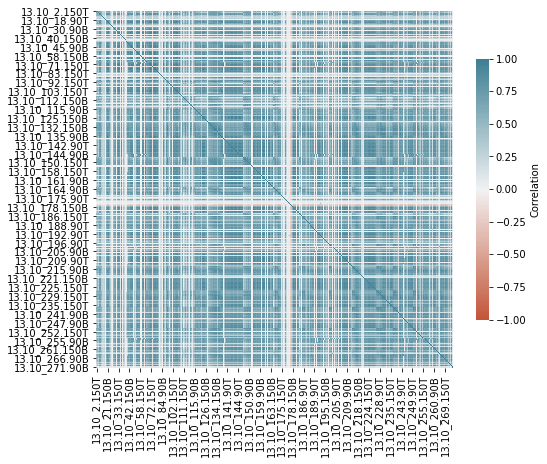

In [14]:
plot_corr(df_tod)

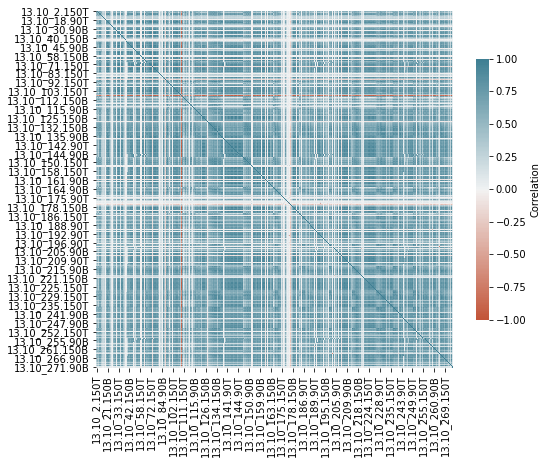

In [24]:
plot_corr(cm_subtract(signal,2,det))

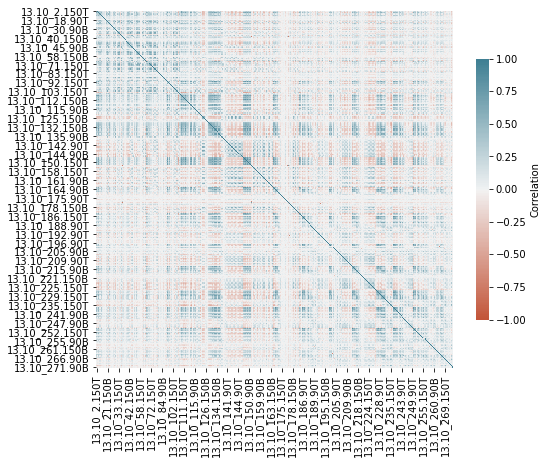

In [25]:
plot_corr(cm_subtract(signal,4,det))